# DQN (DEEP-Q Network):

Énoncé: Entrainer cet agent en utilisant un DQN dans le domaine que vous avez choisi. Pour le code, vous
pouvez ré-utilisez du code (Pytorch ou Tensorflow) cependant il faut le comprendre et le commenter.
Vous pouvez simuler l'environnement d'interaction moyennant des libraires de votre choix qui
s'intègrent facilement à votre environnement (python) de simulation.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random
from typing import List
import tensorflow as tf
from tensorflow.keras import layers, models
from typing import Literal


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
def shortest_angle_diff(target_angle, current_angle):
    diff = target_angle - current_angle
    diff = (diff + math.pi) % (2 * math.pi) - math.pi
    return diff

In [5]:
class ReplayBuffer:
    def __init__(self, state_dim, capacity=100_000):
        """
        Classe permettant de récupérer des échantillons d'états lors de l'entraînement
        (on récupère une situation à un moment aléatoire pour entraîner le modèle sans biais temporels)

        """
        self.state_dim = state_dim
        self.capacity = capacity

        self.states      = np.zeros((capacity, state_dim), dtype=np.float32)
        self.next_states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.actions     = np.zeros((capacity,), dtype=np.int32)
        self.rewards     = np.zeros((capacity,), dtype=np.float32)
        self.dones       = np.zeros((capacity,), dtype=np.float32)

        self.size = 0
        self.ptr  = 0

    def store(self, state, action, reward, next_state, done):
        """
        state / next_state : shape (state_dim,)
        action : int
        reward : float
        done   : bool
        """
        self.states[self.ptr]      = state
        self.next_states[self.ptr] = next_state
        self.actions[self.ptr]     = action
        self.rewards[self.ptr]     = reward
        self.dones[self.ptr]       = float(done)

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        """
        Renvoie un échantillon aléatoire:
        (states, actions, rewards, next_states, dones)
        """
        assert self.size >= batch_size, "Pas assez d'échantillons dans le buffer"
        idxs = np.random.randint(0, self.size, size=batch_size)

        batch_states      = self.states[idxs]
        batch_actions     = self.actions[idxs]
        batch_rewards     = self.rewards[idxs]
        batch_next_states = self.next_states[idxs]
        batch_dones       = self.dones[idxs]

        return batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones


def select_action(state, q_network, n_actions, epsilon):
    """
    state : np.array de shape (state_dim,)
    q_network : réseau de neurone
    epsilon : float dans [0,1]
    """
    # Tirage exploration / exploitation
    if np.random.rand() < epsilon:
        # EXPLORATION : action aléatoire
        return np.random.randint(0, n_actions)
    else:
        # EXPLOITATION : on choisit l'action avec Q max
        state_input = state[None, :]
        q_values = q_network(state_input).numpy()[0]
        action = int(np.argmax(q_values))
        return action


In [ ]:
class Position():
    """
    Classe Position:
        distance: Calcul la distance entre la position courante et la position prise en entrée
        add: modifie la position courante de dx et dy
        get_angle: donne l'angle entre deux objet Position
        copy: renvoie une copie de la position
    """
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def distance(self, other: "Position") -> float:
        return math.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)

    def add(self, dx: float, dy: float):
        self.x += dx
        self.y += dy

    def get_angle(self, other: "Position") -> float:
        delta_x = other.x - self.x
        delta_y = other.y - self.y
        return math.atan2(delta_y, delta_x)

    def copy(self) -> "Position":
        return Position(self.x, self.y)


class Direction():
    """
        Classe Direction:
            rotate: modifie l'angle de la direction courante de delta
            to_vector: transforme l'angle en un vecteur de Position(x, y)
            copy: renvoie un angle
    """
    def __init__(self, angle: float):
        self.angle = angle

    def rotate(self, delta: float):
        self.angle += delta

    def to_vector(self, speed: float) -> (float, float):
        dx = math.cos(self.angle) * speed
        dy = math.sin(self.angle) * speed
        return dx, dy

    def copy(self) -> "Direction":
        return Direction(self.angle)

class BoidsParams():
    """
    Paramètres de Boids selon lesquels on va entraîner notre modèle
    cohesion: proximité au centre du banc
    alignment: alignement à la direction du reste du banc
    separation: distance aux différents membres du banc
    vision_range: distance en pixels à laquelle l'individu peut voir
    min_distance: distance minimale à ses voisins
    """
    def __init__(self):
        self.w_cohesion = 0.03
        self.w_alignment = 0.07
        self.w_separation = 0.2
        self.vision_range = 90
        self.min_distance = 12

class Poisson():
    """
    params_set pour plusieurs bancs séparés:
        - speed = 2.5
        - vision_range = 50
        - vision_angle = math.pi * 1.25
        - alignment_range = 40
        - max_turn = 0.3
        - min_distance = 15
        - w_cohesion = 0.02
        - w_alignment = 0.06
        - w_separation = 0.12

    params_set pour banc unique soudé:
        - speed = 2.5
        - vision_range = 90
        - vision_angle = math.pi * 1.25
        - alignment_range = 80
        - max_turn = 0.3
        - min_distance = 12
        - w_cohesion = 0.03
        - w_alignment = 0.07
        - w_separation = 0.12
        
        
    """
    def __init__(self,
                    pos: Position,
                    dir: Direction,
                    speed: float = 2.5,
                    params = BoidsParams(),
                    vision_angle: float = math.pi * 1.25,
                    alignment_range: float = 80,
                    max_turn: float = 0.3,

                ):
        self.pos = pos
        self.dir = dir
        self.speed = speed
        self.params = params
        self.vision_angle = vision_angle
        self.alignment_range = alignment_range
        self.max_turn = max_turn

    def is_in_vision_cone(self, other_fish: "Poisson") -> bool:
        distance = self.pos.distance(other_fish.pos)

        if distance > self.params.vision_range:
            return False

        angle_to_neighbor = self.pos.get_angle(other_fish.pos)

        angle_diff = shortest_angle_diff(angle_to_neighbor, self.dir.angle)

        # Si la différence d'angle est plus petite que la moitié de l'angle de vision,
        # alors le poisson est dans le cône.
        if abs(angle_diff) < self.vision_angle / 2.0:
            return True

        return False

    def cohesion(self, fish_list: List["Poisson"]):
        mean = Position(0, 0)
        fish_count = 0
        # On parcourt les poissons visibles et pas trop proches, puis on calcule la moyenne de leurs positions
        # et on ajuste la rotation du poisson pour s'y diriger
        for fish in fish_list:
            if fish is self:
                continue
            distance = self.pos.distance(fish.pos)
            if distance <= self.params.min_distance:
                continue
            if self.is_in_vision_cone(fish):
                    mean.x += fish.pos.x
                    mean.y += fish.pos.y
                    fish_count += 1
        if fish_count != 0:
            mean.x /= fish_count
            mean.y /= fish_count
            target_angle = self.pos.get_angle(mean)
            raw_turn = shortest_angle_diff(target_angle, self.dir.angle)
            angle_to_turn = max(-self.max_turn, min(self.max_turn, raw_turn))
            self.dir.rotate(self.params.w_cohesion * angle_to_turn)

    def alignment(self, fish_list: List["Poisson"]):
        sum_cos = 0
        sum_sin = 0
        fish_count = 0

        # On parcourt les poissons voisins et on calcule la moyenne de leurs directions
        # et on ajuste la direction du poisson courant pour s'y diriger
        for fish in fish_list:
            if fish is self:
                continue

            distance = self.pos.distance(fish.pos)

            if distance < self.params.min_distance:
                continue

            if distance < self.alignment_range and self.is_in_vision_cone(fish):

                sum_cos += math.cos(fish.dir.angle)
                sum_sin += math.sin(fish.dir.angle)
                fish_count += 1

        if fish_count != 0:
            # Calcul de l'angle moyen à partir de la moyenne des vecteurs
            avg_cos = sum_cos / fish_count
            avg_sin = sum_sin / fish_count
            mean_angle = math.atan2(avg_sin, avg_cos)

            max_turn = 0.3  # en radians
            raw_turn = shortest_angle_diff(mean_angle, self.dir.angle)
            angle_to_turn = max(-max_turn, min(max_turn, raw_turn))
            self.dir.rotate(self.params.w_alignment * angle_to_turn)

    def separation(self, fish_list: List["Poisson"]):
        """
            Vérifie si des poissons sont trop proches du poisson courant 
        """
        separation_vector = (0.0, 0.0)
        fish_count = 0
        for fish in fish_list:
            if fish is self:
                continue
            distance = self.pos.distance(fish.pos)

            if distance > 0 and distance < self.params.min_distance:
                angle_to_neighbor = self.pos.get_angle(fish.pos)

                magnitude = 1.0 - (distance / self.params.min_distance)

                dx_flee = math.cos(angle_to_neighbor + math.pi) * magnitude
                dy_flee = math.sin(angle_to_neighbor + math.pi) * magnitude
                separation_vector = (separation_vector[0] + dx_flee, separation_vector[1] + dy_flee)
                fish_count += 1

        if fish_count != 0:
            flee_angle = math.atan2(separation_vector[1], separation_vector[0])
            max_turn = 0.3
            raw_turn = shortest_angle_diff(flee_angle, self.dir.angle)
            angle_to_turn = max(-max_turn, min(max_turn, raw_turn))
            self.dir.rotate(self.params.w_separation * angle_to_turn)


    def wrap_position(self, width: int, height: int):
        if self.pos.x < 0:
            self.pos.x += width
        elif self.pos.x > width:
            self.pos.x -= width

        if self.pos.y < 0:
            self.pos.y += height
        elif self.pos.y > height:
            self.pos.y -= height

    def apply_random_fluctuation(self, max_turn_deg: float = 0.5):
        """
        Ajoute une petite rotation aléatoire pour maintenir un léger désordre.
        """
        # Convertir le degré en radian
        max_turn_rad = math.radians(max_turn_deg)

        # Générer une rotation aléatoire entre -max_turn_rad et +max_turn_rad
        random_turn = random.uniform(-max_turn_rad, max_turn_rad)
        self.dir.rotate(random_turn)

    def update(self, fish_list: List["Poisson"], width: int, height: int, is_agent: bool = False):
        """
            Applique les règles de Boids aux individus du banc hors notre agent

        Args:
            fish_list (List[&quot;Poisson&quot;]): _description_
            width (int): la largeur de la fenêtre 
            height (int): la hauteur de la fenêtre
            is_agent (bool, optional): est-ce que le poisson courant est l'agent. Faux par défaut.
        """
        if not is_agent:
            self.cohesion(fish_list)
            self.alignment(fish_list)
            self.separation(fish_list)
            self.apply_random_fluctuation()
        else:
            pass

        dx, dy = self.dir.to_vector(self.speed)
        self.pos.add(dx, dy)

        self.wrap_position(width, height)

class fishEnv:
    def __init__(self, width, height, n_fish: int = 30):
        self.width = width
        self.height = height
        self.n_fish = n_fish
        self.agent_idx = 0
        self.params = BoidsParams()
        self.timestep = 0
        self.max_steps = 2000
        self.fish_list: List["Poisson"] = []
        self._init_fishes()

    def _init_fishes(self):
        self.fish_list = []
        for _ in range(self.n_fish):
            x = random.randint(0, self.width)
            y = random.randint(0, self.height)
            dir = Direction(random.uniform(-math.pi, math.pi))
            self.fish_list.append(
                Poisson(
                    Position(x, y),
                    dir,
                    params=self.params
                ))

    def reset(self):
        self._init_fishes()

    def step(self):
        for fish in self.fish_list:
            fish.update(self.fish_list, self.width, self.height)

    def reset_rl(self):
        self._init_fishes()
        self.agent_idx = 0
        self.timestep = 0

        state = self.compute_state()
        return state

    def step_rl(self, action):
        """
        On met à jour l'environnement et on calcule la récompense de l'agent suivant l'action qu'il a décidé d'effectuer
        On reset l'environnement si l'agent est beaucoup trop loin du centre ou si on atteint la fin d'une période
        """
        agent = self.fish_list[self.agent_idx]

        delta = math.radians(15)

        if(action == 1): # tourner à gauche
            agent.dir.rotate(delta)
        if(action == 2): # tourner à droite
            agent.dir.rotate(-delta)

        for i, fish in enumerate(self.fish_list):
            is_agent = (i == self.agent_idx)
            fish.update(self.fish_list, self.width, self.height, is_agent=is_agent)
        self.timestep += 1
        reward, dist_center_norm = self.compute_reward()
        next_state = self.compute_state()

        timeout = (self.timestep >= self.max_steps)
        failure = (dist_center_norm > 0.8)

        done = timeout or failure

        info = {
            "timeout": timeout,
            "failure": failure,
            "dist_center_norm": dist_center_norm,
        }

        return next_state, reward, done, info



    def compute_state(self):
        """
            Calcule l'état courant de l'agent sous forme d'un vecteur compact.

            L'état représente une description synthétique de la structure locale
            du banc autour de l'agent, inspirée des règles du modèle Boids.

            Le vecteur d'état est composé de 7 variables :
            ------------------------------------------------
            1. neighbors_count_norm :
                Densité locale normalisée (nombre de voisins visibles).
            2. cos_center, sin_center :
                Direction vers le centre local (ou global en cas d'isolement),
                encodée en cosinus/sinus.
            3. cos_align, sin_align :
                Alignement de l'agent avec la direction moyenne des voisins
                (ou du banc global si aucun voisin n'est visible).
            4. avg_dist_norm :
                Distance moyenne normalisée aux voisins (ou distance au centre global).
            5. danger :
                Indicateur binaire signalant une proximité dangereuse avec un voisin.        
        """
        agent = self.fish_list[self.agent_idx]
        neighbors = []
        Nmax = 10

        # --- Variables d'état (initialisation) ---
        neighbors_count_norm = 0.0
        cos_center = 0.0
        sin_center = 0.0
        cos_align = 0.0
        sin_align = 0.0
        avg_dist_norm = 1.0
        danger = 0.0

        mean_x = 0.0
        mean_y = 0.0
        avg_cos = 0.0
        avg_sin = 0.0
        mean_dist = 0.0

        for fish in self.fish_list:
            if fish is agent:
                continue
            if agent.is_in_vision_cone(fish):
                neighbors.append(fish)

        if len(neighbors) == 0:
            center_x = 0.0
            center_y = 0.0
            sum_cos = 0.0
            sum_sin = 0.0

            for fish in self.fish_list:
                center_x += fish.pos.x
                center_y += fish.pos.y
                sum_cos += math.cos(fish.dir.angle)
                sum_sin += math.sin(fish.dir.angle)

            n_total = len(self.fish_list)
            center_x /= n_total
            center_y /= n_total
            center = Position(center_x, center_y)

            angle_center = agent.pos.get_angle(center)
            delta_center = shortest_angle_diff(angle_center, agent.dir.angle)
            cos_center = math.cos(delta_center)
            sin_center = math.sin(delta_center)

            sum_cos /= n_total
            sum_sin /= n_total
            mean_dir = math.atan2(sum_sin, sum_cos)
            delta_align = shortest_angle_diff(mean_dir, agent.dir.angle)
            cos_align = math.cos(delta_align)
            sin_align = math.sin(delta_align)

            dist_center = agent.pos.distance(center)
            max_dist = math.hypot(self.width, self.height) / 2.0
            avg_dist_norm = min(1.0, dist_center / max_dist)

            neighbors_count_norm = 0.0
            danger = 0.0

            state = [
                neighbors_count_norm,
                cos_center, sin_center,
                cos_align, sin_align,
                avg_dist_norm,
                danger
            ]
            return np.array(state, dtype=np.float32)

        else:
            n = len(neighbors)
            neighbors_count_norm = min(n, Nmax) / Nmax

            for fish in neighbors:
                mean_x += fish.pos.x
                mean_y += fish.pos.y
                avg_cos += math.cos(fish.dir.angle)
                avg_sin += math.sin(fish.dir.angle)
                neighbor_distance = agent.pos.distance(fish.pos)
                mean_dist += neighbor_distance
                if neighbor_distance < agent.params.min_distance:
                    danger = 1.0

            mean_x /= n
            mean_y /= n
            angle_center = agent.pos.get_angle(Position(mean_x, mean_y))
            delta = shortest_angle_diff(angle_center, agent.dir.angle)
            cos_center = math.cos(delta)
            sin_center = math.sin(delta)

            avg_cos /= n
            avg_sin /= n
            mean_dir = math.atan2(avg_sin, avg_cos)
            delta_align = shortest_angle_diff(mean_dir, agent.dir.angle)
            cos_align = math.cos(delta_align)
            sin_align = math.sin(delta_align)

            mean_dist /= n
            avg_dist_norm = min(1.0, mean_dist / agent.params.vision_range)

            state = [
                neighbors_count_norm,
                cos_center, sin_center,
                cos_align, sin_align,
                avg_dist_norm,
                danger
            ]
            return np.array(state, dtype=np.float32)


    def compute_reward(self):
        """
        Calcul de la récompense de l'agent. Celle-ci baisse si:
        - l'agent est loin du centre du banc
        - l'agent n'est pas aligné avec la direction globale du banc
        - l'agent est isolé et a très peu de voisins
        
        
        """
        agent = self.fish_list[self.agent_idx]

        center_x = 0.0
        center_y = 0.0
        sum_cos = 0.0
        sum_sin = 0.0

        neighbors_count = 0
        Nmax = 10

        # poids des termes (à ajuster si besoin)
        w_dist = 1.0
        w_align = 0.5
        w_iso = 0.3

        # 1) centre global + direction moyenne + densité
        for fish in self.fish_list:
            center_x += fish.pos.x
            center_y += fish.pos.y
            sum_cos += math.cos(fish.dir.angle)
            sum_sin += math.sin(fish.dir.angle)
            if agent.is_in_vision_cone(fish) and fish is not agent:
                neighbors_count += 1

        n = len(self.fish_list)
        center_x /= n
        center_y /= n
        center = Position(center_x, center_y)

        dist_center = agent.pos.distance(center)
        max_dist = math.hypot(self.width, self.height) / 2.0
        dist_center_norm = min(dist_center / max_dist, 1.0)   # 0 proche du centre, 1 très loin

        sum_cos /= n
        sum_sin /= n
        mean_dir = math.atan2(sum_sin, sum_cos)
        delta_align = abs(shortest_angle_diff(mean_dir, agent.dir.angle))
        align_norm = min(delta_align / math.pi, 1.0)          # 0 bien aligné, 1 opposé

        neighbors_count_norm = min(neighbors_count, Nmax) / Nmax
        isolation = 1.0 - neighbors_count_norm                # 1 très isolé, 0 entouré

        # pénalité globale
        penalty = (
            w_dist * dist_center_norm +
            w_align * align_norm +
            w_iso * isolation
        )

        # reward "positive" quand tout va bien
        reward = 1.0 - penalty

        return reward, dist_center_norm

In [ ]:
state_dim = 7      
n_actions = 3      # 0: rien, 1: gauche, 2: droite

def build_q_network(state_dim, n_actions):
    inputs = layers.Input(shape=(state_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(n_actions, activation=None)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

q_network = build_q_network(state_dim, n_actions)
target_network = build_q_network(state_dim, n_actions)

# Copie initiale des poids
target_network.set_weights(q_network.get_weights())

q_network.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.Huber()
)

q_network.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,987 (101.51 KB)

 Trainable params: 25,987 (101.51 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
buffer = ReplayBuffer(state_dim=state_dim, capacity=100_000)

gamma = 0.99
batch_size = 64

In [9]:
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.Huber()

In [10]:
def train_step(buffer, batch_size, gamma, q_network, target_network):
    if buffer.size < batch_size:
        return None

    states_b, actions_b, rewards_b, next_states_b, dones_b = buffer.sample(batch_size)

    # a* = argmax_a Q(s', a; q_network)
    q_next_online = q_network(next_states_b).numpy()
    next_actions = np.argmax(q_next_online, axis=1)

    # Q(s', a* ; target_network)
    q_next_target = target_network(next_states_b).numpy()
    max_next_q = q_next_target[np.arange(batch_size), next_actions]

    targets = rewards_b + gamma * (1.0 - dones_b) * max_next_q

    q_values = q_network(states_b).numpy()
    batch_indices = np.arange(batch_size)
    q_values[batch_indices, actions_b] = targets

    loss = q_network.train_on_batch(states_b, q_values)
    return loss

In [ ]:
import tensorflow as tf

def train_dqn_with_metrics(
    env,
    q_network,
    target_network,
    buffer,
    n_actions,
    n_episodes=500,
    batch_size=64,
    gamma=0.99,
    target_update_freq=1000,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay_episodes=150,
    max_steps_per_episode=None,
):
    if max_steps_per_episode is None:
        max_steps_per_episode = env.max_steps

    # --- logs ---
    episode_returns = []
    episode_success = []      # 1 si succès, 0 sinon
    episode_seconds = []      # temps par épisode
    cumulative_seconds = []   # temps cumulé
    success_rate_curve = []   # taux de succès cumulatif à chaque épisode

    total_steps = 0
    t0_global = time.perf_counter()
    n_success = 0

    for episode in range(n_episodes):
        t0_ep = time.perf_counter()

        state = env.reset_rl()
        done = False
        ep_return = 0.0

        frac = min(1.0, episode / epsilon_decay_episodes)
        epsilon = epsilon_start + frac * (epsilon_end - epsilon_start)

        last_info = None

        for step in range(max_steps_per_episode):
            action = select_action(state, q_network, n_actions, epsilon)

            # ---- IMPORTANT: step_rl renvoie info ----
            next_state, reward, done, info = env.step_rl(action)

            buffer.store(state, action, reward, next_state, done)

            state = next_state
            ep_return += reward
            total_steps += 1

            _ = train_step(buffer, batch_size, gamma, q_network, target_network)

            if (total_steps % target_update_freq) == 0:
                target_network.set_weights(q_network.get_weights())

            last_info = info
            if done:
                break

        # --- succès/échec ---
        # succès = on termine par timeout sans failure
        success = 1 if (last_info is not None and last_info["timeout"] and not last_info["failure"]) else 0
        episode_success.append(success)
        if success:
            n_success += 1

        # --- temps ---
        t1_ep = time.perf_counter()
        ep_sec = t1_ep - t0_ep
        episode_seconds.append(ep_sec)

        cum_sec = time.perf_counter() - t0_global
        cumulative_seconds.append(cum_sec)

        # --- logs rewards + taux de succès cumulatif ---
        episode_returns.append(ep_return)
        success_rate = n_success / (episode + 1)
        success_rate_curve.append(success_rate)

        print(f"Ep {episode+1}/{n_episodes} | eps={epsilon:.3f} | return={ep_return:.3f} | success={success} | SR={success_rate:.3f} | t_ep={ep_sec:.2f}s")

    logs = {
        "episode_returns": np.array(episode_returns, dtype=np.float32),
        "episode_success": np.array(episode_success, dtype=np.int32),
        "success_rate_curve": np.array(success_rate_curve, dtype=np.float32),
        "episode_seconds": np.array(episode_seconds, dtype=np.float32),
        "cumulative_seconds": np.array(cumulative_seconds, dtype=np.float32),
    }

    return logs

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dqn_training_logs(logs, window=50):
    episodes = np.arange(len(logs["episode_returns"]))

    returns = logs["episode_returns"]
    success = logs["episode_success"]
    success_rate = logs["success_rate_curve"]
    seconds = logs["episode_seconds"]
    cum_seconds = logs["cumulative_seconds"]

    # --- smoothing ---
    def moving_avg(x, w):
        if len(x) < w:
            return x
        return np.convolve(x, np.ones(w)/w, mode="valid")

    ret_s = moving_avg(returns, window)
    sr_s  = moving_avg(success_rate, window)

    # =========================
    plt.figure(figsize=(16, 10))

    # --- Return ---
    plt.subplot(2, 2, 1)
    plt.plot(episodes, returns, alpha=0.3, label="Return brut")
    plt.plot(episodes[window-1:], ret_s, label=f"Return lissé ({window})", linewidth=2)
    plt.xlabel("Épisode")
    plt.ylabel("Return")
    plt.title("Évolution du return par épisode")
    plt.legend()
    plt.grid()

    # --- Success rate ---
    plt.subplot(2, 2, 2)
    plt.plot(episodes, success_rate, alpha=0.3, label="Success rate brut")
    plt.plot(episodes[window-1:], sr_s, label=f"Success rate lissé ({window})", linewidth=2)
    plt.xlabel("Épisode")
    plt.ylabel("Taux de succès")
    plt.title("Taux de succès")
    plt.legend()
    plt.grid()

    # --- Episode duration ---
    plt.subplot(2, 2, 3)
    plt.plot(episodes, seconds, label="Temps par épisode")
    plt.xlabel("Épisode")
    plt.ylabel("Secondes")
    plt.title("Temps d'entraînement par épisode")
    plt.grid()

    # --- Cumulative time ---
    plt.subplot(2, 2, 4)
    plt.plot(episodes, cum_seconds, label="Temps cumulé", color="red")
    plt.xlabel("Épisode")
    plt.ylabel("Secondes")
    plt.title("Temps d'entraînement cumulé")
    plt.grid()

    plt.tight_layout()
    plt.show()


In [16]:
def evaluate_policy(env, q_network, n_actions, n_episodes=10, max_steps=None, epsilon_eval=0.0):

    all_returns = []

    if max_steps is None:
        max_steps = env.max_steps

    reward_min = -0.8   # min par step
    reward_max =  1.0   # max par step
    denom = reward_max - reward_min

    for ep in range(n_episodes):

        state = env.reset_rl()
        done = False
        ep_reward = 0.0
        steps = 0

        while not done and steps < max_steps:
            action = select_action(state, q_network, n_actions, epsilon_eval)
            next_state, reward, done, info = env.step_rl(action)

            ep_reward += reward
            state = next_state
            steps += 1

        # moyenne par step
        if steps > 0:
            episode_avg = ep_reward / steps
        else:
            episode_avg = reward_min  # cas extrême, mais ne devrait pas arriver

        # normalisation en [0, 1]
        normalized = (episode_avg - reward_min) / denom
        normalized = float(np.clip(normalized, 0.0, 1.0))

        all_returns.append(normalized)
        print(f"[EVAL] Episode {ep+1}/{n_episodes} - avg_reward={episode_avg:.3f} - normalized={normalized:.3f}")

    all_returns = np.array(all_returns, dtype=np.float32)
    mean_return = float(all_returns.mean())
    std_return  = float(all_returns.std())

    print(f"\n[EVAL] Mean normalized return = {mean_return:.3f} | Std = {std_return:.3f}")

    return mean_return, std_return, all_returns


In [ ]:
eval_every = 20

n_episodes = 1000
eval_episodes_idx = []
eval_means = []
eval_stds = []

episode_rewards = []
epsilons = []
total_steps = 0

env = fishEnv(800, 600, n_fish=30)
max_steps_per_episode = env.max_steps # 800 mais baissé à 200 pour réduire le temps d'entraînement

epsilon_start = 1.0
epsilon_end   = 0.05
epsilon_decay_episodes = 600
target_update_freq = 300

env_eval = fishEnv(800, 600, n_fish=50)

logs = {
    "episode": [],
    "ep_return": [],
    "ep_len": [],
    "epsilon": [],
    "success": [],
    "time_sec": [],
}

t0 = time.time()

logs = train_dqn_with_metrics(
    env=env,
    q_network=q_network,
    target_network=target_network,
    buffer=buffer,
    n_actions=n_actions,
    n_episodes=n_episodes,
    batch_size=batch_size,
    gamma=gamma,
    epsilon_start=epsilon_start,
    epsilon_end=epsilon_end,
    epsilon_decay_episodes=epsilon_decay_episodes,
    target_update_freq=target_update_freq,
    max_steps_per_episode=max_steps_per_episode
)

Ep 1/1000 | eps=1.000 | return=-30.890 | success=0 | SR=0.000 | t_ep=3.22s
Ep 2/1000 | eps=0.998 | return=-2.040 | success=0 | SR=0.000 | t_ep=0.31s
Ep 3/1000 | eps=0.997 | return=45.080 | success=0 | SR=0.000 | t_ep=3.59s
Ep 4/1000 | eps=0.995 | return=-4.358 | success=0 | SR=0.000 | t_ep=2.13s
Ep 5/1000 | eps=0.994 | return=-26.612 | success=0 | SR=0.000 | t_ep=5.64s
Ep 6/1000 | eps=0.992 | return=-5.345 | success=0 | SR=0.000 | t_ep=1.74s
Ep 7/1000 | eps=0.991 | return=-26.840 | success=0 | SR=0.000 | t_ep=2.01s
Ep 8/1000 | eps=0.989 | return=-3.286 | success=0 | SR=0.000 | t_ep=0.30s
Ep 9/1000 | eps=0.987 | return=19.722 | success=0 | SR=0.000 | t_ep=3.43s
Ep 10/1000 | eps=0.986 | return=44.023 | success=0 | SR=0.000 | t_ep=7.18s
Ep 11/1000 | eps=0.984 | return=-1.357 | success=0 | SR=0.000 | t_ep=0.20s
Ep 12/1000 | eps=0.983 | return=28.339 | success=0 | SR=0.000 | t_ep=5.46s
Ep 13/1000 | eps=0.981 | return=126.882 | success=0 | SR=0.000 | t_ep=6.58s
Ep 14/1000 | eps=0.979 | retur

In [ ]:
env_eval = fishEnv(800, 600, n_fish=50)

mean_ret, std_ret, returns = evaluate_policy(
    env_eval,
    q_network,
    n_actions=3,
    n_episodes=20,
    epsilon_eval=0.0  # 0 => l'agent suit vraiment sa politique apprise
)

[EVAL] Episode 1/20 - avg_reward=-0.247 - normalized=0.307
[EVAL] Episode 2/20 - avg_reward=0.091 - normalized=0.495
[EVAL] Episode 3/20 - avg_reward=0.272 - normalized=0.596
[EVAL] Episode 4/20 - avg_reward=0.018 - normalized=0.454
[EVAL] Episode 5/20 - avg_reward=-0.073 - normalized=0.404
[EVAL] Episode 6/20 - avg_reward=0.112 - normalized=0.507
[EVAL] Episode 7/20 - avg_reward=0.022 - normalized=0.457
[EVAL] Episode 8/20 - avg_reward=0.107 - normalized=0.504
[EVAL] Episode 9/20 - avg_reward=0.447 - normalized=0.693
[EVAL] Episode 10/20 - avg_reward=0.099 - normalized=0.500
[EVAL] Episode 11/20 - avg_reward=-0.020 - normalized=0.434
[EVAL] Episode 12/20 - avg_reward=0.255 - normalized=0.586
[EVAL] Episode 13/20 - avg_reward=-0.330 - normalized=0.261
[EVAL] Episode 14/20 - avg_reward=0.406 - normalized=0.670
[EVAL] Episode 15/20 - avg_reward=0.364 - normalized=0.647
[EVAL] Episode 16/20 - avg_reward=0.224 - normalized=0.569
[EVAL] Episode 17/20 - avg_reward=0.280 - normalized=0.600
[E

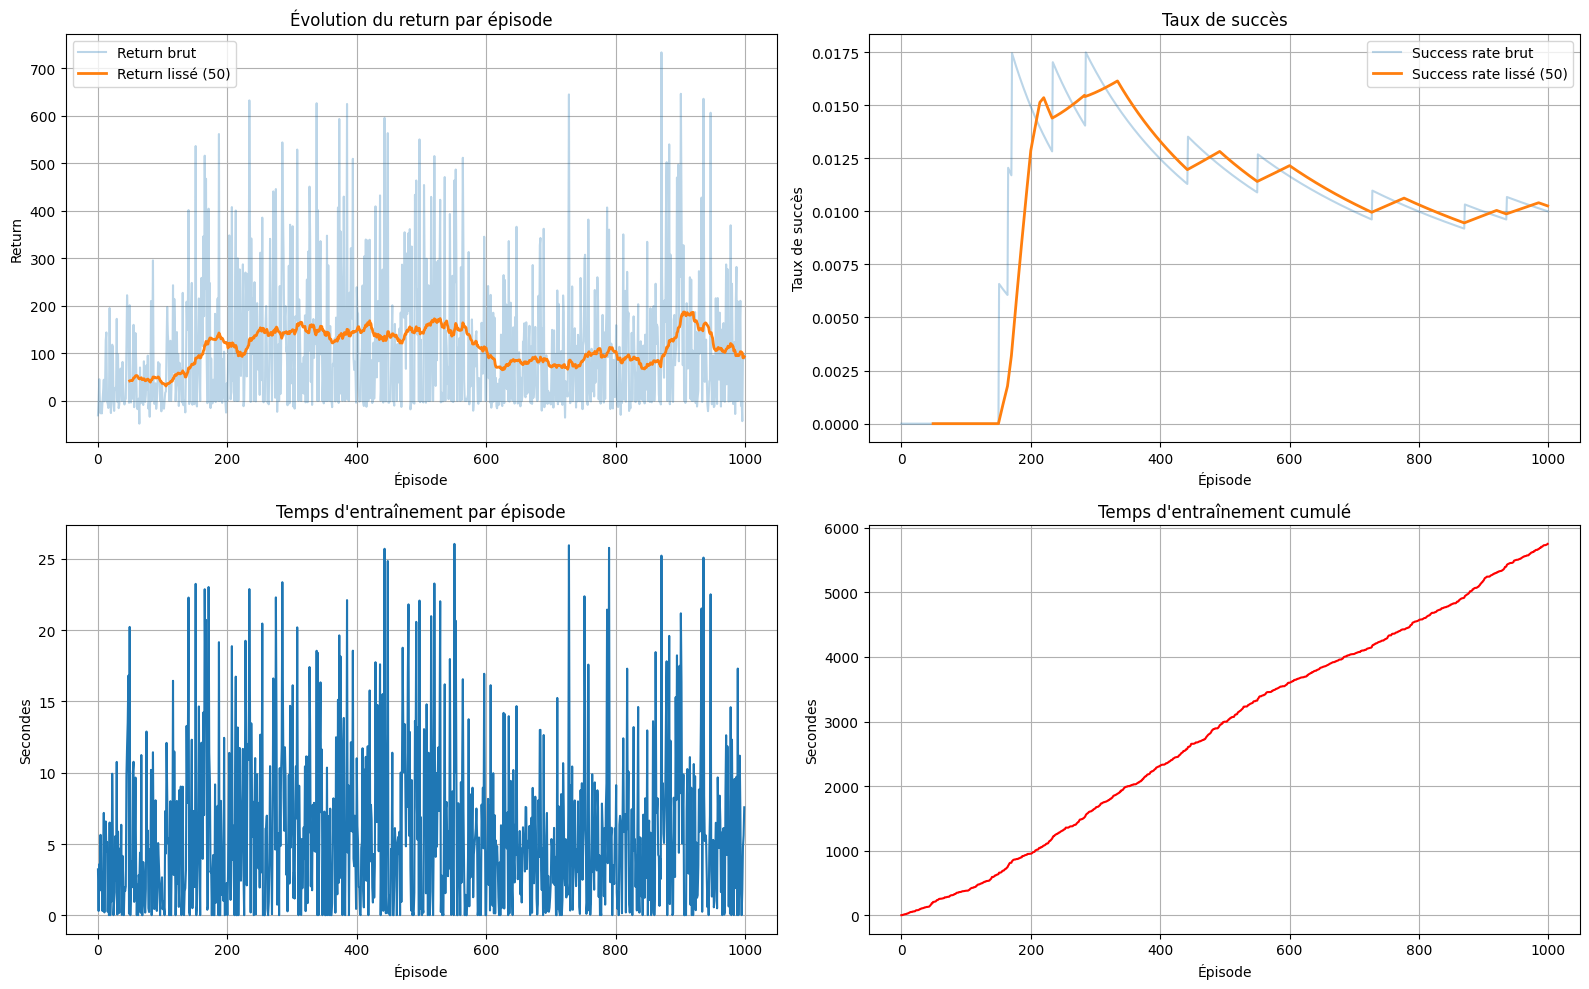

In [27]:
plot_dqn_training_logs(logs)